In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import itertools

from sklearn.metrics import roc_curve, auc
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier
from sklearn.utils import resample


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.DataFrame.from_csv('/Users/kaitlin/ds/metis/metisgh/Puryear_Metis/Project3/noshowclean_n.csv', 
                      header=0, 
                      sep=',', 
                      index_col=0, 
                      parse_dates=True, 
                      encoding=None, 
                      tupleize_cols=None, 
                      infer_datetime_format=False)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  


# 0.0 Initialize the Data

In [3]:
df.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,Text_Sent,Showed_up,woman,delta
0,62,False,True,False,False,False,False,True,True,0
1,56,False,False,False,False,False,False,True,False,0
2,62,False,False,False,False,False,False,True,True,0
3,8,False,False,False,False,False,False,True,True,0
4,56,False,True,True,False,False,False,True,True,0


In [4]:
# add more features
# (T/F) patient showing up for more than one problem

df['2+problems'] = (df['Hypertension']+df['Diabetes']+df['Alcoholism']+df['Handicap']>2)

/anaconda3/lib/python3.6/site-packages/pandas/core/computation/expressions.py:179: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [5]:
df.head()

,Age,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,Text_Sent,Showed_up,woman,delta,2+problems
0,62,False,True,False,False,False,False,True,True,0,False
1,56,False,False,False,False,False,False,True,False,0,False
2,62,False,False,False,False,False,False,True,True,0,False
3,8,False,False,False,False,False,False,True,True,0,False
4,56,False,True,True,False,False,False,True,True,0,False


In [6]:
# define response vector

y0 = df["Showed_up"]

In [7]:
# define feature matrix

X0 = df.drop(['Showed_up'], axis=1)

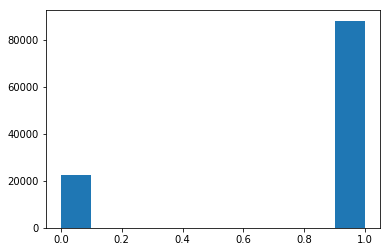

In [8]:
# Visual representation of unbalanced classes. ~4:1 ratio of true:false

plt.hist(y0);

# 1.0 Stratified Train Test Split

In [9]:
# create a stratified train/test split
# Note: classes are still imbalanced

x0train, x0test, y0train, y0test = train_test_split(X0, y0, test_size=0.4, random_state=40, stratify=y0)

In [10]:
# training set response imbalance

y0train.value_counts()

True     52925
False    13391
Name: Showed_up, dtype: int64

## 1.1 Training Data: Upsampling the Minority

In [11]:
# training set response imbalance

train_minority = (y0train==False)
train_minority.value_counts()

False    52925
True     13391
Name: Showed_up, dtype: int64

In [12]:
# combine x and y into one dataset to prepare for upsampling

x0train["Showed_up"]=y0train

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [13]:
# Separate majority (True) and minority (False) classes

train_majority = x0train[x0train.Showed_up==True]
train_minority = x0train[x0train.Showed_up==False]
 
# upsample minority class
train_minority_upsampled = resample(train_minority, 
                                 replace=True,        # sample without replacement
                                 n_samples=52925,     # to match majority class
                                 random_state=123)    # reproducible results
 
# Combine majority class with upsampled minority class
y_train_upsampled = pd.concat([train_minority_upsampled, train_majority])
 
# Display new class counts
y_train_upsampled.Showed_up.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

In [14]:
# reassign x and y (New and improved after upsampling!)

y1train = y_train_upsampled["Showed_up"]
x1train = y_train_upsampled.drop(['Showed_up'], axis=1)

In [15]:
# Confirm that all looks good and True/False are equal

y1train.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

## 1.2 Testing Data: Upsampling the Minority

In [16]:
# test set response imbalance

y0test.value_counts()

True     35283
False     8928
Name: Showed_up, dtype: int64

In [17]:
# combine y and x into one dataframe to prepare for upsampling

x0test["Showed_up"]=y0test

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Separate majority (True) and minority (False) classes

test_majority = x0test[x0test.Showed_up==True]
test_minority = x0test[x0test.Showed_up==False]
 
# Upsample minority class
test_minority_upsampled = resample(train_minority, 
                                 replace=True,        # sample without replacement
                                 n_samples=35283,     # to match majority class
                                 random_state=123)    # reproducible results
 
# Combine minority class with downsampled majority class
y_test_upsampled = pd.concat([test_minority_upsampled, test_majority])
 
# Display new class counts
y_test_upsampled.Showed_up.value_counts()

True     35283
False    35283
Name: Showed_up, dtype: int64

In [19]:
# reassign xtest and ytest (New and improved balanced data!)

y1test = y_train_upsampled["Showed_up"]
x1test = y_train_upsampled.drop(['Showed_up'], axis=1)

In [20]:
# Make sure True/False is equal

y1test.value_counts()

True     52925
False    52925
Name: Showed_up, dtype: int64

# 2.0 Define Functions and Other Useful Tools

## 2.1 Normalize the dataframe because you will need that for knn

In [21]:
# Normalize only x

normalizer = preprocessing.Normalizer()
x1test_norm = normalizer.fit_transform(x1test)
x1train_norm = normalizer.fit_transform(x1train)

## 2.2 Define a Function that will draw Confusion Matrices

In [22]:
# define a function to draw beautiful confusion matrix!

def plot_confusion_matrix(cm, classes,
                         normalize=False,
                         title='Confusion matrix',
                         cmap=plt.cm.Blues):

#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")


# 3.0 Fitting Different Models

## 3.1 K-Nearest Neighbors

In [23]:
# Gotta find the best k value. Iterate through a list and find the largest f1 score
'''
f1_knn = {}
for i in range(50):
    knn = KNeighborsClassifier(n_neighbors=(i+1))
    knn.fit(x1train, y1train)
    y_pred = knn.predict(x1test)
    f1_knn[i+1] = metrics.f1_score(y_pred, y1test)
    '''
# looks like k=30 is a good k value

'\nf1_knn = {}\nfor i in range(50):\n    knn = KNeighborsClassifier(n_neighbors=(i+1))\n    knn.fit(x1train, y1train)\n    y_pred = knn.predict(x1test)\n    f1_knn[i+1] = metrics.f1_score(y_pred, y1test)\n    '

In [24]:
# fit the model to the test set, using k=30

knn = KNeighborsClassifier(n_neighbors=30)
knn.fit(x1train_norm, y1train)
y_pred = knn.predict(x1test_norm)

In [25]:
# print a nice little scorecard for this model

print("Model accuracy: {:.2f}%".format(knn.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, knn.predict(x1test_norm)))

Model accuracy: 70.36%
Model F1 Score: 0.66
             precision    recall  f1-score   support

      False       0.66      0.83      0.74     52925
       True       0.77      0.58      0.66     52925

avg / total       0.72      0.70      0.70    105850



AREA UNDER CURVE: 0.774129386131


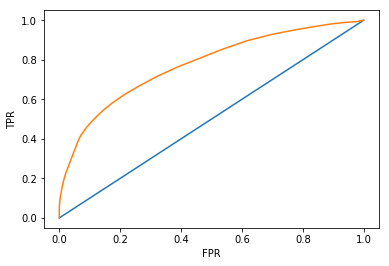

In [26]:
# Plot ROC Curve and print AUC

y_score=knn.predict_proba(x1test_norm)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot([0,1],[0,1]) # Plotting our Baseline
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AREA UNDER CURVE: "+str(roc_auc));

Model accuracy: 70.36%
[[43755  9170]
 [22206 30719]]


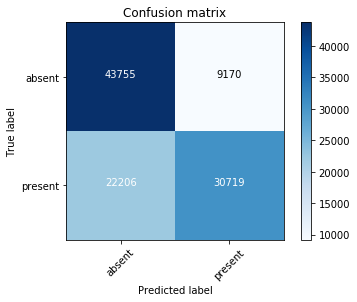

In [27]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

print("Model accuracy: {:.2f}%".format(knn.score(x1train, y1train)*100))
plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.2 Logistic Regression



In [28]:
# fit a logistic regression model, print the f1 score

logistic = LogisticRegression(penalty='l2', 
                              dual=True, 
                              tol=0.0001, 
                              C=200.0, 
                              fit_intercept=True, 
                              intercept_scaling=1, 
                              class_weight='balanced', 
                              random_state=135, 
                              solver='liblinear', 
                              max_iter=100, 
                              multi_class='ovr', 
                              verbose=0, warm_start=False, n_jobs=1)
logistic.fit(x1train,y1train)
y_pred = logistic.predict(x1test)

In [29]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(logistic.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, logistic.predict(x1test_norm)))

Model accuracy: 53.11%
Model F1 Score: 0.16
             precision    recall  f1-score   support

      False       0.00      0.00      0.00     52925
       True       0.50      1.00      0.67     52925

avg / total       0.25      0.50      0.33    105850



AREA UNDER CURVE: 0.623370622995


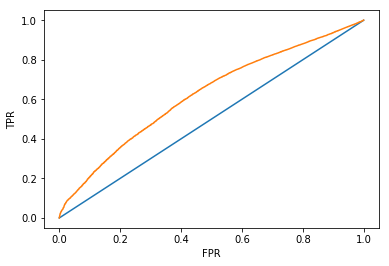

In [30]:
# Plot ROC Curve and print AUC

y_score=logistic.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AREA UNDER CURVE: "+str(roc_auc));

[[51550  1375]
 [48262  4663]]


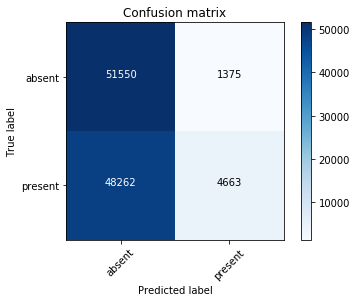

In [31]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.3 Naive Bayes (Bernoulli)

In [32]:
# Fit a Naive Bayes (Bernoulli version) model and print the f1 score

bernoulli = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=None)
bernoulli.fit(x1train, y1train)
y_pred = bernoulli.predict(x1test)

In [33]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(bernoulli.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, bernoulli.predict(x1test_norm)))

Model accuracy: 66.67%
Model F1 Score: 0.57
             precision    recall  f1-score   support

      False       0.61      0.89      0.73     52925
       True       0.80      0.44      0.57     52925

avg / total       0.71      0.67      0.65    105850



AREA UNDER CURVE: 0.672537955936


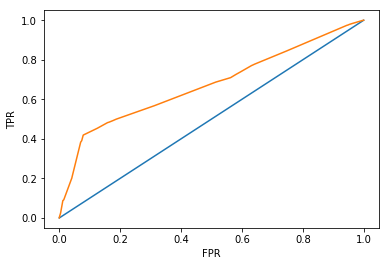

In [34]:
# Plot the ROC Curve and print AUC

y_score=bernoulli.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AREA UNDER CURVE: "+str(roc_auc));

[[47265  5660]
 [29621 23304]]


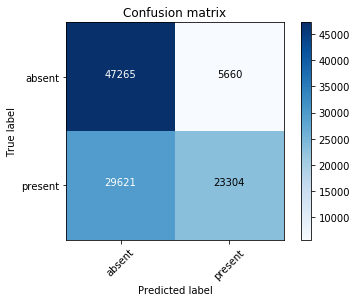

In [35]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.4 Decision Trees

In [36]:
# determining max depth
'''
f1_df={}
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)
for i in range(40):
    decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=(i+30))
    decisiontree.fit(xtrain, ytrain)
    y_pred = decisiontree.predict(xtest)
    f1_df[i+30] = metrics.f1_score(y_pred, ytest)
    '''
# looks like max_depth=60 is the best

"\nf1_df={}\nxtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3)\nfor i in range(40):\n    decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=(i+30))\n    decisiontree.fit(xtrain, ytrain)\n    y_pred = decisiontree.predict(xtest)\n    f1_df[i+30] = metrics.f1_score(y_pred, ytest)\n    "

In [37]:
# Fit a Decision Tree model to the data, with max_depth=60

decisiontree = DecisionTreeClassifier(class_weight = 'balanced', max_depth=60)
decisiontree.fit(x1train, y1train)
y_pred = decisiontree.predict(x1test)

In [38]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(decisiontree.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, decisiontree.predict(x1test_norm)))

Model accuracy: 84.13%
Model F1 Score: 0.83
             precision    recall  f1-score   support

      False       0.67      0.15      0.25     52925
       True       0.52      0.93      0.67     52925

avg / total       0.60      0.54      0.46    105850



AREA UNDER CURVE: 0.928038190959


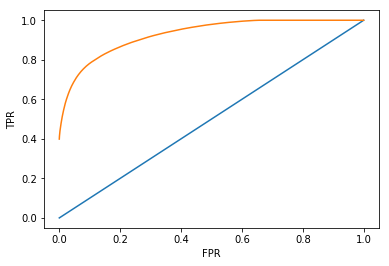

In [39]:
# Plot the ROC Curve and print AUC

y_score=decisiontree.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AREA UNDER CURVE: "+str(roc_auc));

[[47315  5610]
 [11192 41733]]


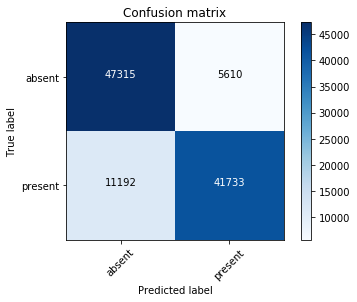

In [40]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

## 3.5 Random Forest

In [41]:
# Fit a Random Forest Model to the dataset

randomforest = RandomForestClassifier(class_weight = 'balanced')
randomforest.fit(x1train, y1train)
y_pred = randomforest.predict(x1test)

In [42]:
# Print a nice little score card for this model

print("Model accuracy: {:.2f}%".format(randomforest.score(x1train, y1train)*100))
print("Model F1 Score: {:.2f}".format(metrics.f1_score(y_pred, y1test)))
print(metrics.classification_report(y1test, randomforest.predict(x1test_norm)))

Model accuracy: 83.78%
Model F1 Score: 0.83
             precision    recall  f1-score   support

      False       0.68      0.15      0.25     52925
       True       0.52      0.93      0.67     52925

avg / total       0.60      0.54      0.46    105850



AREA UNDER CURVE: 0.921377301995


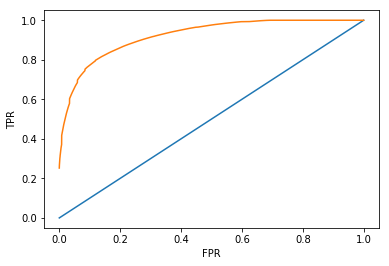

In [43]:
# Plot the ROC Curve and print the AUC

y_score=randomforest.predict_proba(x1test)[:,1]

fpr, tpr,_ = roc_curve(y1test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
print("AREA UNDER CURVE: "+str(roc_auc));

[[46678  6247]
 [10920 42005]]


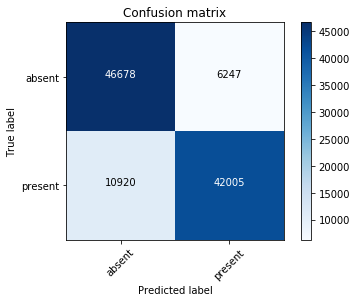

In [44]:
# Print a lovely confusion matrix

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

plot_confusion_matrix(metrics.confusion_matrix(y1test,y_pred), ['absent', 'present'])

# 4.0 Comparing Across Models

0.928038190959 AUC Decision Tree
0.921377301995 AUC Random Forest
0.77401285078 AUC K Nearest Neighbors
0.672537955936 AUC Naive Bayes (Bernoulli)
0.623370622995 AUC Logistic Regression


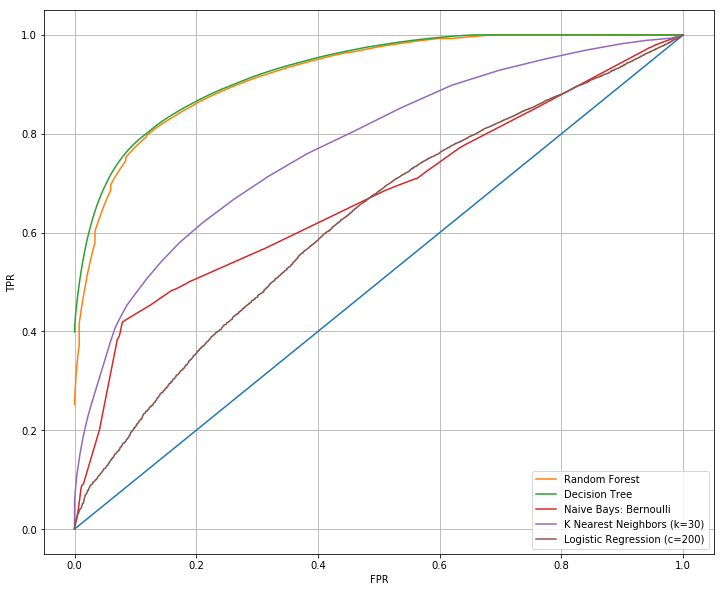

In [45]:
y_rf_score=randomforest.predict_proba(x1test)[:,1]
y_dt_score=decisiontree.predict_proba(x1test)[:,1]
y_nb_score=bernoulli.predict_proba(x1test)[:,1]
y_knn_score=knn.predict_proba(x1test)[:,1]
y_log_score=logistic.predict_proba(x1test)[:,1]

rf_fpr, rf_tpr,_ = roc_curve(y1test, y_rf_score)
dt_fpr, dt_tpr,_ = roc_curve(y1test, y_dt_score)
nb_fpr, nb_tpr,_ = roc_curve(y1test, y_nb_score)
knn_fpr, knn_tpr,_ = roc_curve(y1test, y_knn_score)
log_fpr, log_tpr,_ = roc_curve(y1test, y_log_score)

plt.figure(figsize=(12,10))
# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.plot(rf_fpr,rf_tpr, label='Random Forest')
plt.plot(dt_fpr,dt_tpr, label='Decision Tree')
plt.plot(nb_fpr,nb_tpr, label='Naive Bays: Bernoulli')
plt.plot(knn_fpr,knn_tpr, label='K Nearest Neighbors (k=30)')
plt.plot(log_fpr,log_tpr, label='Logistic Regression (c=200)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.grid(True)

print(str(metrics.auc(dt_fpr, dt_tpr))+" AUC Decision Tree")
print(str(metrics.auc(rf_fpr, rf_tpr))+" AUC Random Forest")
print(str(metrics.auc(knn_fpr, knn_tpr))+" AUC K Nearest Neighbors")
print(str(metrics.auc(nb_fpr, nb_tpr))+" AUC Naive Bayes (Bernoulli)")
print(str(metrics.auc(log_fpr, log_tpr))+" AUC Logistic Regression")
